# Soft Computing - rač. vežba 4

## Implementacija sistema za optičko prepoznavanje karaktera (OCR)

Tokom prethodne četiri vežbe smo implementirali "ceo" sistem za optičko prepoznavanje karaktera, ali smo u tom procesu zanemarili mnoge probleme koje OCR u realnom okruženju sa sobom nosi. Cilj ovih vežbi jeste identifikacija i rešavanje tih problema.

OCR sistemi vrše optičko prepoznavanje tekstualnih sadržaja sa fotografija, gde je fotografija ulazni parametar sistema. Tačnost i performantnost sistema će u mnogome zavisiti od pretpostavke o ulaznoj fotografiji. Pošto se takva fotografija pravi u realnom okruženju, normalno je za očekivati dosta spoljnih uticaja. Ukoliko pretpostavimo da ulazna fotografija neće biti pod uticajem određenog broja faktora iz okruženja sistem može da se pojednostavi. Recimo, kamere u industijskim pogonima prave fotografije u okruženju u kome se nivo osvetljenja može kontrolisati, uređaj za fotografisanje je uvek isti i pravi fotografije koje su "sličnog" oblika.

Do sada smo OCR sistem implementirali uz pretpostavku da je fotografija idealna i da je tekstualni sadržaj na njoj u prost. Međutim, to najčešće nije slučaj. Ulazna fotografija će obično izgledati ovako:
<img src="images/cifre.jpg"></img>


In [1]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import collections
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.spatial import distance

# k-means
from sklearn.cluster import KMeans

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

### Obrada digitalne slike
Obrada digitalne slike predstavlja prvi skup aktivnosti u sistemu za OCR. Cilj ovog skupa aktivnosti jeste prilagođavanje ulazne fotografije da bi se nad njom mogla vršiti analiza sadržaja. Obrada digitalne slike može biti dosta složen proces, pošto bi on trebao biti u stanju da obradi bilo kakvu ulaznu fotografiju. Proces analize digitalne slike će biti mnogo jednostavniji ukoliko se fotografija prethodno dobro obradi i ukloni vecina suma.

In [2]:
#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def image_bin_adaptive(image_gs):
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

#### Neuniformna osvetljenost fotografije
Prva aktivnost u OCR sistemu jeste obrada digitalne slike, odnosno segmentacija. Cilj segmentacije jeste klasifikovanje piksela fotografije u one koji pripadaju sadržaju i one koji pripadaju pozadini. Do sada smo za segmentaciju koristili metode bazirane na računanju praga - <b><i>threshold</i></b>. Ukoliko se za celu fotografiju pronađe jedan prag segmentacije, problem se javlja ako su delovi fotografije osetno manje ili više osvetljeni od ostatka fotografije. Ovaj problem se može rešiti uz korišćenje adaptivnog threshold-a. Na taj način se može rešiti problem neuniformne osvetljenosti fotografije, koji je bio prisutan i na prethodnom primeru.

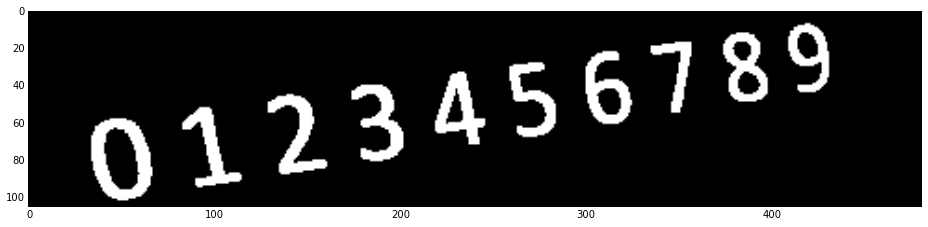

In [11]:
# učitavanje digitalne slike
image_color = load_image('images/cifre2.jpg')
# formiranje binarne slike
img = image_bin(image_gray(image_color))
#img=image_bin_adaptive(image_gray(image_color))
img=remove_noise(img)
#img=invert(img)
display_image(img)

#### Šum na fotografiji nakon segmentacije
Proces segmentacije će pokušati da klasifikuje piksele tako da ih obeleži da pripadaju sadržaju ili pozadini, ali ne mora da znači da će u tome biti 100% uspešan. Na fotografiji koja je rezultat procesa segmentacije može postojati šum koji može znatno otežati analizu ovakve fotografije u narednim koracima OCR-a. Zbog toga je takav šum potrebno otkloniti u što većoj meri u ovim ranim fazama.

#Uklanjanje šuma
U narednom odeljku je prikazana jedna metoda uklanjanja šuma. Nad fotografijom sa belom pozadinom i crnim tekstom izvršena je dilatacija kako bi se crne površine smanjile i uklonio potencijalni šum, a nakon toga smo erozijom proširili crne površine da bi ih vratili u prethodno stanje.

In [8]:
# Uklanjanje šuma
def remove_noise(binary_image):
    ret_val = erode(dilate(binary_image))
    ret_val = invert(ret_val)
    return ret_val

### Analiza digitalne slike
Analiza digitalne slike počinje kreiranjem skupa regiona(kontura) sa binarne slike.

###### * NAPOMENA: OpenCV po default-u vrši selektovanje belih površina na crnoj pozadini i sliku je potrebno postaviti u taj oblik pre pozivanja metode FindContours.


Takav skup regiona je potrebno analizirati i izvršiti njihovo prepoznavanje posredstvom veštačke neuronske mreže. Problem predstavlja činjenica da region ne mora izgledati uvek isto, iako predstavlja isti karakter. Jedan primer takve situacije jeste rotacija.

#### Zarotirani simboli na fotografiji
Svaki region se skalira na dimenzije 28x28 i formira matricu, a nakon toga se pretvara u vektor od 784 elementa. Očigledno je da će takva matrica izgledati drugačije ukoliko je region zarotiran, što će rezultovati činjenicom da ćemo na ulaz neuronske mreže dovesti ulazni vektor koji će jako loše opisivati region koji bi on trebalo da predstavlja. Posledica će biti loša predikcija od strane veštačke neuronske mreže. Zbog toga je regione potrebno zarotirati tako da se oni postave u prirodan položaj.

# TODO 1
Tačke regiona je potrebno rotirati oko tačke <b>(c<sub>x</sub>, c<sub>y</sub>)</b> za zadati ugao <b>(α = π/2-|θ|)</b> gde su (c<sub>x</sub>, c<sub>y</sub> i theta) parametri dobijeni iz osobina regiona. Na ovaj način treba da se dobiju slike regiona koje su ‘relativno’ vertikalne.

Formula za rotiranje tačke sa koordinatama (x,y) za ugao α oko tačke sa koordinatama (c<sub>x</sub>, c<sub>y</sub>):
<img src="images/rotacijaFormula.jpg"></img>


In [12]:
# TODO 1 - Rotiranje regiona
def rotate_regions(contours,angles,centers,sizes):
    '''Funkcija koja vrši rotiranje regiona oko njihovih centralnih tačaka
    Args:
        contours: skup svih kontura [kontura1, kontura2, ..., konturaN]
        angles:   skup svih uglova nagiba kontura [nagib1, nagib2, ..., nagibN]
        centers:  skup svih centara minimalnih pravougaonika koji su opisani 
                  oko kontura [centar1, centar2, ..., centarN]
        sizes:    skup parova (height,width) koji predstavljaju duzine stranica minimalnog
                  pravougaonika koji je opisan oko konture [(h1,w1), (h2,w2), ...,(hN,wN)]
    Return:
        ret_val: rotirane konture'''
    ret_val = []
    for idx, contour in enumerate(contours):
                
        angle = angles[idx]
        cx,cy = centers[idx]
        height, width = sizes[idx]
        if width<height:
            angle+=90
            
        # Rotiranje svake tačke regiona oko centra rotacije
        alpha = np.pi/2 - abs(np.radians(angle))
        region_points_rotated = np.ndarray((len(contour), 2), dtype=np.int16)
        for i, point in enumerate(contour):
            x = point[0]
            y = point[1]
            
            #TODO 1 - izračunati koordinate tačke nakon rotacije
            rx = np.sin(alpha)*(x-cx) - np.cos(alpha)*(y-cy) + cx
            ry = np.cos(alpha)*(x-cx) + np.sin(alpha)*(y-cy) + cy
            
            
            region_points_rotated[i] = [rx,ry]
        ret_val.append(region_points_rotated)
        

    return ret_val

#### Simboli koji je sastoje iz više regiona
Činjenica da se jedan simbol ne mora sastojati iz samo jednog regiona nama može predstavljati problem (npr. slova i,j,ž,ć,...). Zbog toga je potrebno izvršiti spajanje kukica i kvačica u okolini simbola pre slanja podataka na predikciju neuronskoj mreži.

# TODO 2
Spojiti kukice i kvačice sa osnovnim slovima.
<img src="images/slovo.jpg"/>

In [13]:
# TODO 2
def merge_regions(contours):
    '''Funkcija koja vrši spajanje kukica i kvačica sa osnovnim karakterima
    Args:
        contours: skup svih kontura (kontura - niz tacaka bele boje)
    Return:
        ret_val: skup kontura sa spojenim kukicama i kvacicama'''
    ret_val = []
    merged_index = [] #lista indeksa kontura koje su već spojene sa nekim

    for i,contour1 in enumerate(contours): #slova
        if i in merged_index:
            continue
        min_x1 = min(contour1[:,0])
        max_x1 = max(contour1[:,0])
        min_y1 = min(contour1[:,1])
        max_y1 = max(contour1[:,1])
        for j,contour2 in enumerate(contours): #kukice
            if j in merged_index or i == j:
                continue
            min_x2 = min(contour2[:,0])
            max_x2 = max(contour2[:,0])
            min_y2 = min(contour2[:,1])
            max_y2 = max(contour2[:,1])
            
            #TODO 2 - izvršiti spajanje kukica iznad slova
            #spajanje dva niza je moguće obaviti funkcijom np.concatenate((contour1,contour2))
            if len(contour1)/2>len(contour2): #provera pretpostavke da je contour1 slovo
                
                if (min_y1-max_y2)<max(max_y1-min_y1,max_y2-min_y2)/2 \
                and (min_x2>min_x1-5 and max_x2<max_x1+5):
                    #spajanje kontura
                    ret_val.append(np.concatenate((contour1,contour2)))
                    merged_index.append(i)
                    merged_index.append(j)
            
            
                    
    #svi regioni koji se nisu ni sa kim spojili idu u listu kontura, bez spajanja
    for idx,contour in enumerate(contours):
        if idx not in merged_index:
            ret_val.append(contour)
        
    return ret_val



# TODO 2 - TEST
image_test2_original = load_image('images/kukice.jpg')
image_test2 = remove_noise(image_bin(image_gray(image_test2_original)))
img2, contours_borders2, hierarchy2 = cv2.findContours(image_test2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
contours2 = []
for contour2 in contours_borders2:
    center, size, angle = cv2.minAreaRect(contour2)
    xt,yt,h,w = cv2.boundingRect(contour2)
    region_points2 = []
    for i in range (xt,xt+h):
        for j in range(yt,yt+w):
            dist = cv2.pointPolygonTest(contour2,(i,j),False)
            if dist>=0 and image_test2[j,i]==255: # da li se tacka nalazi unutar konture?
                region_points2.append([i,j])
    contours2.append(np.asarray(region_points2))
contour_count = merge_regions(contours2)
print "Regions found: ",len(contour_count)
if len(contour_count) == 10:
    print "TODO 2 Test - Passed"
else:
    print "TODO 2 Test - Failed"

Regions found:  10
TODO 2 Test - Passed


# TODO 3
U nastavku se nalazi funkcija za selekciju regiona od interesa koja nam je poznata sa prethodnih vežbi, a koja je sada proširena tako da vrši rotaciju svih regiona i spajanje kukica i kvačica iznad slova pozivanjem funkcija iz prethodna dva zadatka.

Nakon spajanja kukica i kvačica na red dolazi skaliranje regiona na dimenzije 28x28. Region je sada niz tačaka čije su koordinate apsolutne koordinate na fotografiji sa koje su regioni preuzeti. Kako bi se isekao pravougaonik oko regiona potrebno je proći kroz sve tačke regiona i koordinate svake od njih prebaciti iz apsolutnih u relativne koordinate u odnosu na poziciju tačke unutar regiona.

In [14]:
# TODO 3
def select_roi(image_orig, image_bin):
    
    img, contours_borders, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    contours = []
    contour_angles = []
    contour_centers = []
    contour_sizes = []
    for contour in contours_borders:
        center, size, angle = cv2.minAreaRect(contour)
        xt,yt,h,w = cv2.boundingRect(contour)

        region_points = []
        for i in range (xt,xt+h):
            for j in range(yt,yt+w):
                dist = cv2.pointPolygonTest(contour,(i,j),False)
                if dist>=0 and image_bin[j,i]==255: # da li se tacka nalazi unutar konture?
                    region_points.append([i,j])
        contour_centers.append(center)
        contour_angles.append(angle)
        contour_sizes.append(size)
        contours.append(region_points)
    
    #Postavljanje kontura u vertikalan polozaj
    contours = rotate_regions(contours, contour_angles, contour_centers, contour_sizes)
    
    #spajanje kukica i kvacica
    contours = merge_regions(contours)
    
    regions_dict = {}
    for contour in contours:
    
        min_x = min(contour[:,0])
        max_x = max(contour[:,0])
        min_y = min(contour[:,1])
        max_y = max(contour[:,1])

        region = np.zeros((max_y-min_y+1,max_x-min_x+1), dtype=np.int16)
        for point in contour:
            x = point[0]
            y = point[1]
            
             # TODO 3 - koordinate tacaka regiona prebaciti u relativne koordinate
            '''Pretpostavimo da gornja leva tačka regiona ima apsolutne koordinate (100,100).
            Ako uzmemo tačku sa koordinatama unutar regiona, recimo (105,105), nakon
            prebacivanja u relativne koordinate tačka bi trebala imati koorinate (5,5) unutar
            samog regiona.
            '''
            region[y-min_y,x-min_x] = 255


        
        regions_dict[min_x] = [resize_region(region), (min_x,min_y,max_x-min_x,max_y-min_y)]
        
    sorted_regions_dict = collections.OrderedDict(sorted(regions_dict.items()))
    sorted_regions = np.array(sorted_regions_dict.values())
    
    sorted_rectangles = sorted_regions[:,1]
    region_distances = [-sorted_rectangles[0][0]-sorted_rectangles[0][2]]
    for x,y,w,h in sorted_regions[1:-1, 1]:
        region_distances[-1] += x
        region_distances.append(-x-w)
    region_distances[-1] += sorted_rectangles[-1][0]
    
    return image_orig, sorted_regions[:, 0], region_distances

# Start


Broj prepoznatih regiona: 10


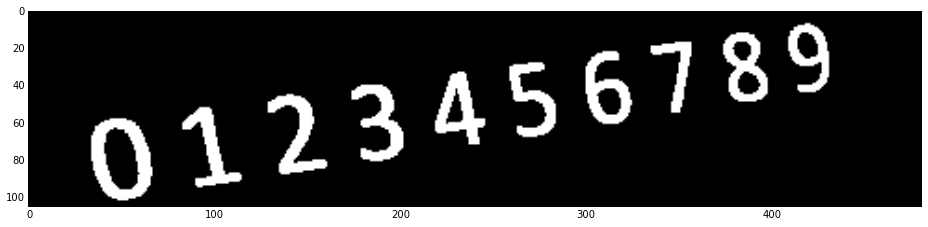

In [16]:
image_test_original = load_image('images/cifre2.jpg')
image_test = remove_noise(image_bin(image_gray(image_test_original)))

display_image(image_test)
selected_regions, letters, region_distances = select_roi(image_test_original.copy(), image_test)
print 'Broj prepoznatih regiona:', len(letters)

In [17]:
def create_ann():
    
    ann = Sequential()
    # Postavljanje slojeva neurona mreže 'ann'
    ann.add(Dense(input_dim=784, output_dim=128,init="glorot_uniform"))
    ann.add(Activation("sigmoid"))
    ann.add(Dense(input_dim=128, output_dim=27,init="glorot_uniform"))
    ann.add(Activation("sigmoid"))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann


#### Prepoznavanje razmaka između slova i između reči u rečenici
Kao rešenje moguće je koristiti K-means algoritam i klasifikovati razmak između regiona na dve grupe:
* Razmak između slova u reči
* Razmak između reči

In [18]:
def display_result(outputs, alphabet, k_means):
    '''
    Funkcija određuje koja od grupa predstavlja razmak između reči, a koja između slova, i na osnovu
    toga formira string od elemenata pronađenih sa slike.
    Args:
        outputs: niz izlaza iz neuronske mreže.
        alphabet: niz karaktera koje je potrebno prepoznati
        kmeans: obučen kmeans objekat
    Return:
        Vraća formatiran string
    '''
    # Odrediti indeks grupe koja odgovara rastojanju između reči, pomoću vrednosti iz k_means.cluster_centers_
    w_space_group = max(enumerate(k_means.cluster_centers_), key = lambda x: x[1])[0]
    result = alphabet[winner(outputs[0])]
    for idx, output in enumerate(outputs[1:,:]):
        # Iterativno dodavati prepoznate elemente kao u vežbi 2, alphabet[winner(output)]
        # Dodati space karakter u slučaju da odgovarajuće rastojanje između dva slova odgovara razmaku između reči.
        # U ovu svrhu, koristiti atribut niz k_means.labels_ koji sadrži sortirana rastojanja između susednih slova.
        if (k_means.labels_[idx] == w_space_group):
            result += ' '
        result += alphabet[winner(output)]
    return result

### Obučavanje veštačke neuronske mreže
Naredni segment koda vrši učitavanje slike koja predstavlja obučavajući skup, definiše alfabet svih karaktera koji se nalaze na slici za obučavanje, redom sa leva na desno, kao i sam postupak obučavanja veštačke neuronske mreže.

In [19]:
image_test_original_obucavanje = load_image('images/obucavajuciSkup.jpg')
image_test_obucavanje = remove_noise(image_bin(image_gray(image_test_original_obucavanje)))

selected_test_obucavanje, letters_obucavanje, region_distances_obucavanje = select_roi(image_test_original_obucavanje.copy(), image_test_obucavanje)
region_distances_obucavanje = np.array(region_distances_obucavanje).reshape(len(region_distances_obucavanje), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_obucavanje)
inputs_obucavanje = prepare_for_ann(letters_obucavanje)
alphabet = ['a','s','d','f','g','h','j','k','l','č','ć','ž','š','p','o','i','u','z','t','r','e','c','v','b','n','m','đ']
outputs_obucavanje = convert_output(alphabet)
ann = create_ann()
ann = train_ann(ann, inputs_obucavanje, outputs_obucavanje)

### Predikcija na osnovu obučene mreže
Naredni segment koda vrši predikciju, odnosno prepoznavanje simbola sa fotografije za testiranje. U ovoj fazi se koristi veštačka neuronska mreža koja je definisana u prethodnom koraku i na osnovu nje se vrši predikcija rezultata.

In [20]:
image_test_original = load_image('images/test1.jpg')
image_test = remove_noise(image_bin(image_gray(image_test_original)))

selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test)
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)
inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32))
print display_result(results_test, alphabet, k_means_test)

čitanje povećava inteligenciju


#### Prepoznavanje teksta koji se nalazi u više redova